<a href="https://colab.research.google.com/github/ayumu-1212/tabelog_analysis/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import PIL
import torch
import torchvision
from torchvision import models
import torch.nn as nn

In [ ]:
# google driveのマウント
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# プログレスバー導入
from tqdm import tqdm
import time

In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, label_path, transform=None):
        x = []
        y = []
        
        with open (label_path, 'r') as infh:
            header = next(infh)
            for line in infh:
                d = line.replace('\n', "").split(",")
                x.append(os.path.join(os.path.dirname(label_path), d[0]))
                if d[1] == '':
                    y.append(float(0))
                else:
                    y.append(float(d[1]))
        
        self.x = x
        self.y = torch.from_numpy(np.array(y)).float().view(-1, 1)
        
        self.transform = transform
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        img = PIL.Image.open(self.x[i]).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)
            
        return img, self.y[i]

In [ ]:
from torchvision.transforms.transforms import Resize
normalize = torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(224),
    torchvision.transforms.ToTensor(),
    normalize
])

data_dir = "./drive/MyDrive/Colab Notebooks/CATechAccel/data/train_labels_20220223054616.csv"
full_dataset = MyDataset(data_dir, transform=transform)

# 店舗ごとに分けられるように
train_ratio = 0.8
train_size = int(int(train_ratio * len(full_dataset)) / 3) * 3
valid_size = len(full_dataset) - train_size

train_dataset, valid_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, valid_size]
)

# print(f"full: {len(full_dataset)} -> train: {len(train_dataset)}, test: {len(val_dataset)}")

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=2)

len(full_dataset): 3003, train_size: 2400


In [ ]:
# 1画像1スコアでの出力
arch = "resnet50"
model = models.__dict__[arch](pretrained=True)

# 最後のfc層だけout_features=1に変更
# model.fc = nn.Linear(model.fc.in_features, 1)
# Add Sigmoid
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 1),
    nn.Sigmoid()
)

for p in model.parameters(): 
#   print("p:{}\n".format(p))
  p.requires_grad=False

# fc層とbiasだけ学習はさせる
model.fc[0].weight.requires_grad=True
model.fc[0].bias.requires_grad=True

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# model.train()

# data = next(iter(train_loader))
# inputs, labels = data
# labels /= 5
# inputs = inputs.to(device)
# labels = labels.to(device)
# # optimizer.zero_grad()
# outputs = model(inputs)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
# 1店舗1スコアでの出力
arch = "resnet50"
model = models.__dict__[arch](pretrained=True)

# 最後のfc層だけout_features=1に変更
# model.fc = nn.Linear(model.fc.in_features, 1)
# Add Sigmoid
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 1),
    nn.Sigmoid()
)

for p in model.parameters(): 
#   print("p:{}\n".format(p))
  p.requires_grad=False

# fc層とbiasだけ学習はさせる
model.fc[0].weight.requires_grad=True
model.fc[0].bias.requires_grad=True

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# model.train()

# data = next(iter(train_loader))
# inputs, labels = data
# labels /= 5
# inputs = inputs.to(device)
# labels = labels.to(device)
# # optimizer.zero_grad()
# outputs = model(inputs)

In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
for i in model.parameters():
    print(i)

ストリーミング出力は最後の 5000 行に切り捨てられました。
          [-4.1268e-03,  5.5602e-03,  8.4699e-03]],

         [[ 2.2172e-02,  3.3722e-02,  1.8594e-02],
          [ 5.6022e-03,  3.6581e-02,  4.2553e-02],
          [ 7.8837e-03,  1.4450e-02,  5.5292e-03]]],


        [[[ 1.9120e-03,  5.3587e-03, -4.9032e-03],
          [ 1.6983e-02, -1.4963e-02, -5.4303e-03],
          [ 1.6449e-02,  4.5332e-03, -8.4380e-03]],

         [[-5.2710e-03, -1.9042e-03, -8.1417e-03],
          [-1.6533e-02,  2.6227e-03,  6.3464e-03],
          [-7.2472e-03, -9.8770e-03,  1.1998e-02]],

         [[-9.7690e-03, -1.4907e-03,  9.1513e-04],
          [-2.2082e-02, -3.9295e-02, -1.7943e-02],
          [ 8.8720e-03, -2.5237e-02, -2.9072e-03]],

         ...,

         [[-2.2149e-03, -5.3252e-04,  2.0031e-03],
          [ 2.5545e-03,  1.0076e-02, -6.0019e-03],
          [-1.3694e-05, -1.4340e-02, -6.7655e-04]],

         [[ 1.0820e-02,  7.4360e-03, -9.7529e-03],
          [ 3.2754e-02,  2.4370e-02,  1.2826e-02],
          [ 3.1693e-0

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

In [ ]:
train_loss = []
valid_loss = []

for epoch in tqdm(range(50)):
  # 学習
  model.train()
  running_train_loss = 0.0
  with torch.set_grad_enabled(True):
    for data in train_loader:
      inputs, labels = data
      labels /= 5
      inputs = inputs.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      # print("loss.item():{}\n".format(loss.item()))
      running_train_loss += loss.item()
      loss.backward()
      optimizer.step()

    #   print(outputs)

  train_loss.append(running_train_loss / len(train_dataset))
  
  # 検証
  model.eval()
  running_valid_loss = 0.0
  with torch.set_grad_enabled(False):
    for data in valid_loader:
      inputs, labels = data
      labels /= 5
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      running_valid_loss += loss.item()

    #   print(outputs)

  valid_loss.append(running_valid_loss / len(valid_dataset))
#   print('#epoch:{}\ttrain loss: {}'.format(epoch, running_train_loss / len(train_loss)))
  print('#epoch:{}\ttrain loss: {}\tvalid loss: {}'.format(epoch,
                                                running_train_loss / len(train_loss), 
                                                running_valid_loss / len(valid_loss)))

  2%|▏         | 1/50 [00:19<15:43, 19.26s/it]

#epoch:0	train loss: 0.24398154637310654	valid loss: 0.1095383707433939


  4%|▍         | 2/50 [00:38<15:16, 19.09s/it]

#epoch:1	train loss: 0.12016962171765044	valid loss: 0.012023169547319412


  6%|▌         | 3/50 [00:57<14:57, 19.09s/it]

#epoch:2	train loss: 0.07962650134383391	valid loss: 0.007918573295076689


  8%|▊         | 4/50 [01:16<14:35, 19.04s/it]

#epoch:3	train loss: 0.05991881445515901	valid loss: 0.004200424591545016


 10%|█         | 5/50 [01:35<14:14, 18.98s/it]

#epoch:4	train loss: 0.048693377734161915	valid loss: 0.02394580841064453


 12%|█▏        | 6/50 [01:54<14:04, 19.18s/it]

#epoch:5	train loss: 0.039887914666906	valid loss: 0.003786016022786498


 14%|█▍        | 7/50 [02:14<13:47, 19.24s/it]

#epoch:6	train loss: 0.03407805459573865	valid loss: 0.0033920095302164555


 16%|█▌        | 8/50 [02:33<13:26, 19.20s/it]

#epoch:7	train loss: 0.02960716019879328	valid loss: 0.0008529921615263447


 18%|█▊        | 9/50 [02:52<13:03, 19.11s/it]

#epoch:8	train loss: 0.026250218118851382	valid loss: 0.0017914371306283607


 20%|██        | 10/50 [03:10<12:40, 19.02s/it]

#epoch:9	train loss: 0.023804394819308072	valid loss: 0.0022173409815877676


 22%|██▏       | 11/50 [03:29<12:19, 18.96s/it]

#epoch:10	train loss: 0.021993344723754985	valid loss: 0.01068414104255763


 24%|██▍       | 12/50 [03:48<12:00, 18.95s/it]

#epoch:11	train loss: 0.01959953621068659	valid loss: 0.0014248092581207554


 26%|██▌       | 13/50 [04:07<11:43, 19.01s/it]

#epoch:12	train loss: 0.01817640949649593	valid loss: 0.0013997284874606591


 28%|██▊       | 14/50 [04:26<11:23, 19.00s/it]

#epoch:13	train loss: 0.01707959094450676	valid loss: 0.007593205996922084


 30%|███       | 15/50 [04:45<11:00, 18.87s/it]

#epoch:14	train loss: 0.01602200128448506	valid loss: 0.008293425664305687


 32%|███▏      | 16/50 [05:04<10:40, 18.84s/it]

#epoch:15	train loss: 0.014542123841238208	valid loss: 0.0008875667117536068


 34%|███▍      | 17/50 [05:22<10:20, 18.82s/it]

#epoch:16	train loss: 0.013726762194624719	valid loss: 0.0009890879942652058


 36%|███▌      | 18/50 [05:41<10:04, 18.90s/it]

#epoch:17	train loss: 0.012980013257927366	valid loss: 0.0008930358388978574


 38%|███▊      | 19/50 [06:01<09:48, 18.98s/it]

#epoch:18	train loss: 0.012300050063793989	valid loss: 0.0016622469564409631


 40%|████      | 20/50 [06:20<09:30, 19.01s/it]

#epoch:19	train loss: 0.011624056822620332	valid loss: 0.0009069457300938666


 42%|████▏     | 21/50 [06:39<09:10, 18.97s/it]

#epoch:20	train loss: 0.01115185024017202	valid loss: 0.0008513618238447677


 44%|████▍     | 22/50 [06:57<08:46, 18.82s/it]

#epoch:21	train loss: 0.010696636174212803	valid loss: 0.0009448413567786866


 46%|████▌     | 23/50 [07:16<08:28, 18.83s/it]

#epoch:22	train loss: 0.01033061755436432	valid loss: 0.00513537827393283


 48%|████▊     | 24/50 [07:35<08:12, 18.95s/it]

#epoch:23	train loss: 0.009715173131553456	valid loss: 0.0010862128692679107


 50%|█████     | 25/50 [07:54<07:53, 18.92s/it]

#epoch:24	train loss: 0.009272182467393577	valid loss: 0.0006799398455768823


 52%|█████▏    | 26/50 [08:13<07:30, 18.79s/it]

#epoch:25	train loss: 0.00892463289738561	valid loss: 0.0007921506543285572


 54%|█████▍    | 27/50 [08:32<07:14, 18.88s/it]

#epoch:26	train loss: 0.008564173955366843	valid loss: 0.0008520264075034194


 56%|█████▌    | 28/50 [08:50<06:54, 18.83s/it]

#epoch:27	train loss: 0.008191331755369902	valid loss: 0.0006405686976255051


 58%|█████▊    | 29/50 [09:09<06:34, 18.76s/it]

#epoch:28	train loss: 0.007984702423182798	valid loss: 0.0006153889337618803


 60%|██████    | 30/50 [09:28<06:14, 18.74s/it]

#epoch:29	train loss: 0.007656344833473365	valid loss: 0.0005805911108230551


 62%|██████▏   | 31/50 [09:47<05:58, 18.86s/it]

#epoch:30	train loss: 0.007554652950456066	valid loss: 0.0035400844870075105


 64%|██████▍   | 32/50 [10:06<05:39, 18.86s/it]

#epoch:31	train loss: 0.007179233456554357	valid loss: 0.0005171300654183142


 66%|██████▌   | 33/50 [10:24<05:18, 18.74s/it]

#epoch:32	train loss: 0.007013077770049374	valid loss: 0.000612092289057645


 68%|██████▊   | 34/50 [10:43<05:01, 18.84s/it]

#epoch:33	train loss: 0.006867241162313696	valid loss: 0.003396829535417697


 70%|███████   | 35/50 [11:02<04:42, 18.85s/it]

#epoch:34	train loss: 0.006562586404782321	valid loss: 0.00051415033106293


 72%|███████▏  | 36/50 [11:21<04:24, 18.86s/it]

#epoch:35	train loss: 0.00647264781420947	valid loss: 0.0031793350353837013


 74%|███████▍  | 37/50 [11:40<04:04, 18.84s/it]

#epoch:36	train loss: 0.006162495580438927	valid loss: 0.00022748873783023777


 76%|███████▌  | 38/50 [11:59<03:47, 18.94s/it]

#epoch:37	train loss: 0.006010362587403506	valid loss: 0.0004375310259331998


 78%|███████▊  | 39/50 [12:18<03:27, 18.89s/it]

#epoch:38	train loss: 0.0062531345607474064	valid loss: 0.008282456069420546


 80%|████████  | 40/50 [12:36<03:07, 18.73s/it]

#epoch:39	train loss: 0.005753054498927668	valid loss: 0.0009801340056583285


 82%|████████▏ | 41/50 [12:55<02:49, 18.84s/it]

#epoch:40	train loss: 0.005522467800779495	valid loss: 0.0003207547067687279


 84%|████████▍ | 42/50 [13:14<02:31, 18.95s/it]

#epoch:41	train loss: 0.005517853404550503	valid loss: 0.0023959255555555934


 86%|████████▌ | 43/50 [13:33<02:12, 18.86s/it]

#epoch:42	train loss: 0.0053527591760855085	valid loss: 0.0025432019732719246


 88%|████████▊ | 44/50 [13:52<01:52, 18.83s/it]

#epoch:43	train loss: 0.005161981802137399	valid loss: 0.0004422694010744718


 90%|█████████ | 45/50 [14:11<01:34, 18.96s/it]

#epoch:44	train loss: 0.005044959741644562	valid loss: 0.00033986281293133896


 92%|█████████▏| 46/50 [14:30<01:16, 19.08s/it]

#epoch:45	train loss: 0.004935277441172334	valid loss: 0.0003869118391657653


 94%|█████████▍| 47/50 [14:49<00:57, 19.03s/it]

#epoch:46	train loss: 0.004901134671564115	valid loss: 0.0022266672408961237


 96%|█████████▌| 48/50 [15:08<00:37, 18.92s/it]

#epoch:47	train loss: 0.004687760444843055	valid loss: 0.00029570512803426635


 98%|█████████▊| 49/50 [15:26<00:18, 18.79s/it]

#epoch:48	train loss: 0.004702085353510112	valid loss: 0.002465107079063143


100%|██████████| 50/50 [15:45<00:00, 18.92s/it]

#epoch:49	train loss: 0.004491214056033641	valid loss: 0.00031769187189638614


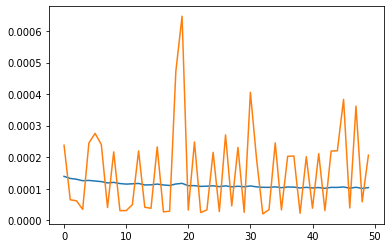

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(train_loss, label='train')
ax.plot(valid_loss, label='valid')
fig.show()

In [ ]:
outputs

tensor([[0.6346],
        [0.6543],
        [0.6722],
        [0.6510],
        [0.6382],
        [0.6307],
        [0.6512],
        [0.6481],
        [0.6219],
        [0.7170],
        [0.6438],
        [0.7184],
        [0.6770],
        [0.6435],
        [0.6717],
        [0.6542],
        [0.6523],
        [0.7312],
        [0.6511],
        [0.6710],
        [0.6586],
        [0.7623],
        [0.6236],
        [0.6839],
        [0.6375]], device='cuda:0')

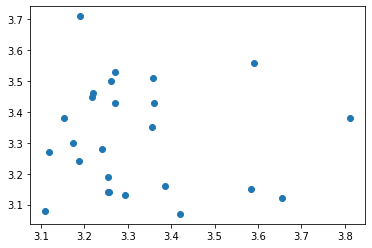

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()
outputs *= 5
ax.scatter(outputs.cpu().detach().numpy(), labels.cpu().detach().numpy())
fig.show()

- 重みは更新しない（->p.requires_grad=False）
- 回帰問題にするために、out_features=1に設定
- dataloaderのときにNormalizeを変更、画像サイズも調整 -> h:224, w:224

In [ ]:
class RegressionNet(torch.nn.Module):
    
    def __init__(self):
        super(RegressionNet, self).__init__()
        
        self.relu = torch.nn.ReLU()
        
        self.conv1 = torch.nn.Conv2d(3, 16, 3)
        self.pool1 = torch.nn.MaxPool2d(2, 2)
        self.conv2 = torch.nn.Conv2d(16, 32, 3)
        self.pool2 = torch.nn.MaxPool2d(2, 2)

        self.fc1 = torch.nn.Linear(32 * 78 * 78, 1024)
        self.fc2 = torch.nn.Linear(1024, 1024)
        self.fc3 = torch.nn.Linear(1024, 1)
        
    def forward(self, x):
        # x = torch.nn.functional.relu(self.conv1(x))
        # print(torch.Tensor.size(x))
        # -> torch.Size([64, 3, 320, 320])
        x = self.conv1(x)
        # print(torch.Tensor.size(x))
        # -> torch.Size([64, 16, 318, 318])
        x = self.relu(x)
        # print(torch.Tensor.size(x))
        # -> torch.Size([64, 16, 318, 318])
        x = self.pool1(x)
        # print(torch.Tensor.size(x))
        # -> torch.Size([64, 16, 159, 159])
        # x = torch.nn.functional.relu(self.conv2(x))
        x = self.conv2(x)
        # print(torch.Tensor.size(x))
        # -> torch.Size([64, 32, 157, 157])
        x = self.relu(x)
        # print(torch.Tensor.size(x))
        # -> torch.Size([64, 32, 157, 157])
        x = self.pool2(x)
        # print(torch.Tensor.size(x))
        # -> torch.Size([64, 32, 78, 78])

        x = x.view(-1, 32 * 78 * 78) # 多次元から1次元に無理やり戻しすぎ
        x = self.relu(x) # 別の活性化関数に変更（tanhなど）
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        print("x:{}".format(x))
        # sigmoid関数を使って0 - 1の値に変換する
        
        return x